# Atividade 6 - Classificador Naive Bayes com PCA

Realizar validação cruzada para testar naiveBayes utilizando:

    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2
    
● Dependendo do seu dataset (tipos de variáveis) dá para utilizar uma implementação pronta de Naive Bayes ou ter que implementar a sua (talvez dê para combinar diferentes implementações)

● Quem tem missing values – possibilidade de não tratar antes e deixar isso para o algoritmo EM

● Para cada dataset fazer:

● Calibração do parâmetro utilizado na estimação MAP (no mínimo 2 valores: 0.1 e 1) via validação cruzada 10x – escolher aquele que apresentar maior acurácia média;

● Calcular os valores médios de revocação (sensibilidade), precisão e acurácia.

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing

# PCA
from sklearn.decomposition import PCA

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st


import warnings

warnings.filterwarnings("ignore")

random_state=5007

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


## Pré-Processamento

In [3]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [4]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [5]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [6]:
df_imp = df_processed.copy()

In [7]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## PCA (matriz de correlação)

In [8]:
scaler = preprocessing.StandardScaler()
X_imp = df_imp.drop('Biopsy', axis=1)

X_std = pd.DataFrame(scaler.fit_transform(X_imp) , columns = X_imp.columns.tolist())

#X_std.describe()

In [9]:
pca_corr = PCA()
pca_corr.fit(X_std)

#pd.DataFrame(pca_corr.get_covariance(), columns = df_imp.columns.tolist()).head()

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
autovalores_corr = pca_corr.explained_variance_.tolist()
variancia_corr = pca_corr.explained_variance_ratio_
variancia_acumulada_corr = np.cumsum(variancia_corr.tolist())

print('\tAuto-valores\tVariância explicada\tVariância acumulada')
print()

for (num,item) in enumerate(variancia_acumulada_corr):
    print(num+1,'\t' + '%0.3f' % autovalores_corr[num] + '\t\t' +'%0.3f' %variancia_corr[num],'\t\t\t'+ '%0.2f' %item)

	Auto-valores	Variância explicada	Variância acumulada

1 	5.116		0.155 			0.15
2 	3.028		0.092 			0.25
3 	2.473		0.075 			0.32
4 	2.078		0.063 			0.38
5 	2.017		0.061 			0.45
6 	1.716		0.052 			0.50
7 	1.546		0.047 			0.54
8 	1.361		0.041 			0.59
9 	1.278		0.039 			0.62
10 	1.235		0.037 			0.66
11 	1.064		0.032 			0.69
12 	1.029		0.031 			0.72
13 	1.008		0.031 			0.76
14 	0.935		0.028 			0.78
15 	0.857		0.026 			0.81
16 	0.843		0.026 			0.83
17 	0.811		0.025 			0.86
18 	0.795		0.024 			0.88
19 	0.745		0.023 			0.91
20 	0.654		0.020 			0.93
21 	0.572		0.017 			0.94
22 	0.478		0.014 			0.96
23 	0.320		0.010 			0.97
24 	0.276		0.008 			0.98
25 	0.234		0.007 			0.98
26 	0.175		0.005 			0.99
27 	0.125		0.004 			0.99
28 	0.092		0.003 			0.99
29 	0.076		0.002 			1.00
30 	0.066		0.002 			1.00
31 	0.030		0.001 			1.00
32 	0.008		0.000 			1.00
33 	0.000		0.000 			1.00
34 	0.000		0.000 			1.00
35 	0.000		0.000 			1.00


In [11]:
max_var = []
for num in range(0, len(variancia_corr)):
    if variancia_corr[num] > 0.02: # threshold - queremos variancia mais que 0.02
        max_var.append(num)

best_var = max(max_var)
# +1 porque a tabela acima começa com 1 e nao com 0 
print('{} - {:.3f}'.format(best_var+1,variancia_corr[best_var]))

19 - 0.023


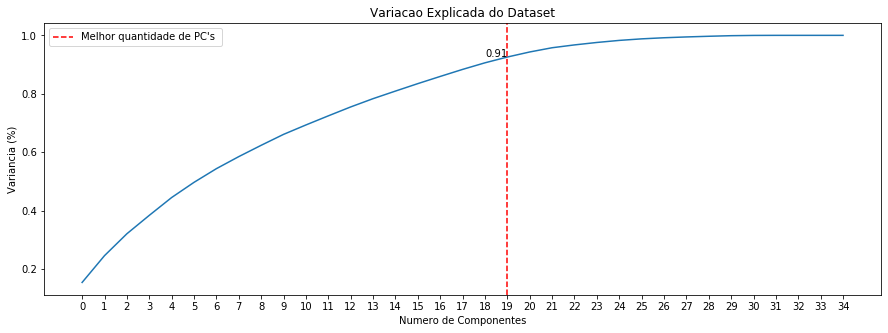

In [12]:
# Plotando o somatório cumulativo da variação explicada
PCA_MinMax = plt.figure(figsize=(15,5))
plt.plot(np.cumsum(variancia_corr))
plt.xlabel('Numero de Componentes')
plt.ylabel('Variancia (%)') #for each component
plt.xticks(range(0,35))
plt.axvline(best_var+1, 0, 1, label='Melhor quantidade de PC\'s ',  color='r', linestyle='--')
plt.legend()
plt.title('Variacao Explicada do Dataset')
plt.annotate('{:.2f}'.format(variancia_acumulada_corr[best_var]),
            xy=(best_var, variancia_acumulada_corr[best_var]+0.02), )
plt.show()

PCA_MinMax.savefig("PCA_MinMax.png", bbox_inches='tight', dpi=600)

In [13]:
numero_pcs = 12

pca_corr = PCA(n_components=numero_pcs)
df_pca = pd.DataFrame(pca_corr.fit_transform(X_std))
df_pca = df_pca.join(df_imp['Biopsy'])
#df_pca

## Stratified Cross- Validation

### Dataset Desbalanceado

In [14]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, random_state,alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False):
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
    

    
    # Scores (das futuras metricas)
    scores = []

    alpha_min = int(alpha_min*100)
    alpha_max = int(alpha_max*100 +1)
    alpha_step = int(alpha_step*100)
    
    # Testa varios alphas
    for alpha_int in range (alpha_min, alpha_max, alpha_step):
        alpha = alpha_int * 0.01
        
        #Naive Bayes
        gnb = GaussianNB(var_smoothing=alpha)
        
        # Folds
        for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
            fold_number = fold
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_test, y_test = X.iloc[test_index], y.iloc[test_index]

            # quantidade de classes dentro da fold
            count_classes_fold = y.iloc[test_index].value_counts()
            # proporções
            prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
            prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
            print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                count_classes_fold[1],
                                                                                count_classes_fold[0], 
                                                                                count_classes_fold.sum(),
                                                                                prop_pos, prop_neg))

            
            # Aplica Gaussian Naive Bayes sobre o dataset e classifica fold de teste
            y_pred = gnb.fit(X_train, y_train).predict(X_test)
            print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
             % (X_test.shape[0], (y_test != y_pred).sum()))
           # print("Number of points predicted as Pos: %d"
           #  % ((y_pred == 1).sum()))

            # Scores do model (utilizados dados nao-balanceados) - dados de teste
            recall = recall_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            scores.append([alpha, fold_number, precision, recall, accuracy])
            
    return np.array(scores)
    



### Dataset Balanceado

In [15]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, random_state, alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False):
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []

    alpha_min = int(alpha_min*100)
    alpha_max = int(alpha_max*100 +1)
    alpha_step = int(alpha_step*100)
    
    # Testa varios alphas
    for alpha_int in range (alpha_min, alpha_max, alpha_step):
        alpha = alpha_int * 0.01
        
        #Naive Bayes
        gnb = GaussianNB(var_smoothing=alpha)
        
        # Folds
        for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
            fold_number = fold
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_test, y_test = X.iloc[test_index], y.iloc[test_index]


            # SMOTETomek (apenas os dados de treino)
            print('\tBalanceando dados de treino fold {}...'.format(fold_number))
            X_train, y_train = cc.fit_resample(X_train, y_train)
            print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                     y_train.value_counts()[0], 
                                                                                     y_train.value_counts()[1], 
                                                                                     ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                     ((y_train.value_counts()[1]/len(y_train))*100)))
            # quantidade de classes dentro da fold
            count_classes_fold = y_test.value_counts()
            # proporções
            prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
            prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
            print('\t\tDados de teste (desbalanceados)')
            print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                count_classes_fold[1],
                                                                                count_classes_fold[0], 
                                                                                count_classes_fold.sum(),
                                                                                prop_pos, prop_neg))


           
            # Aplica um novo Gaussian Naive Bayes sobre o dataset e classifica fold de teste
            y_pred = gnb.fit(X_train, y_train).predict(X_test)
            print("\t\t\tNumero de instancias classificadas erradas do total de %d instancias : %d"
             % (X_test.shape[0], (y_test != y_pred).sum()))
           # print("Number of points predicted as Pos: %d"
           #  % ((y_pred == 1).sum()))

            # Scores do model (utilizados dados nao-balanceados) - dados de teste
            recall = recall_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            scores.append([alpha, fold_number, precision, recall, accuracy])
            
    return np.array(scores)


## Calculando Precisão, Revocação e Acurácia

### Dataset Desbalanceado

In [16]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_pca, k, random_state,alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'Alpha', 1:'Fold', 2: 'Precision', 3: 'Recall', 4: 'Accuracy'}) 
print('----'*20)

K-Fold com K = 10
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erra

In [17]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-PCA_NB.xlsx', 
                           encoding='utf-8-sig')

,Alpha,Fold,Precision,Recall,Accuracy
0,0.1,1.0,0.285714,0.800000,0.872093
1,0.1,2.0,0.600000,0.600000,0.953488
2,0.1,3.0,0.375000,0.600000,0.918605
3,0.1,4.0,1.000000,0.666667,0.976744
4,0.1,5.0,0.250000,0.333333,0.883721


### Dataset Balanceado

In [18]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_pca, k, random_state,alpha_min = 0.1, alpha_max = 1, alpha_step = 0.1, shuffle=False))
scores_balanced = scores_balanced.rename(columns = {0: 'Alpha', 1:'Fold', 2: 'Precision', 3: 'Recall', 4: 'Accuracy'}) 
print('----'*20)

K-Fold com K = 10
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
			Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
			Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
			Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de

In [19]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-PCA_NB.xlsx', 
                           encoding='utf-8-sig')

,Alpha,Fold,Precision,Recall,Accuracy
0,0.1,1.0,0.266667,0.800000,0.860465
1,0.1,2.0,0.625000,1.000000,0.965116
2,0.1,3.0,0.333333,0.800000,0.895349
3,0.1,4.0,0.833333,0.833333,0.976744
4,0.1,5.0,0.187500,0.500000,0.813953


## Calculando valor de alpha com maior acurácia

### Dataset Desbalanceado

In [20]:
mean_unbalanced = scores_unbalanced.groupby(['Alpha']).mean().drop('Fold', axis = 1)
mean_unbalanced

,Precision,Recall,Accuracy
Alpha,,,
0.1,0.430238,0.533333,0.913748
0.2,0.437792,0.460000,0.919562
0.3,0.462857,0.406667,0.925376
0.4,0.328333,0.263333,0.921874
0.5,0.298333,0.206667,0.924213
0.6,0.305000,0.190000,0.930055
0.7,0.320000,0.170000,0.930055
0.8,0.320000,0.150000,0.931204
0.9,0.216667,0.110000,0.933557


In [21]:
max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

0.9

### Dataset Balanceado

In [22]:
mean_balanced = scores_balanced.groupby(['Alpha']).mean().drop('Fold', axis = 1)
mean_balanced

,Precision,Recall,Accuracy
Alpha,,,
0.1,0.431845,0.733333,0.905609
0.2,0.444327,0.733333,0.911436
0.3,0.479253,0.716667,0.920739
0.4,0.494444,0.716667,0.924227
0.5,0.498611,0.676667,0.925376
0.6,0.510974,0.656667,0.930027
0.7,0.534881,0.656667,0.937031
0.8,0.552381,0.640000,0.939371
0.9,0.565714,0.640000,0.940534


In [23]:
max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

1.0

## Calculando intervalo de confiança da Acurácia para o melhor alpha

### Dataset Desbalanceado

In [24]:
# Usando apenas folds com o melhor alpha
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced['Alpha'] == max_alpha_unbalanced, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.6f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.6f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.6f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.933557, IC = [0.922, 0.945]
Recall: Média = 0.110000, IC = [-0.001, 0.221]
Precisão: Média = 0.216667, IC = [-0.033, 0.467]


### Dataset Balanceado

In [25]:
# Usando apenas folds com o melhor alpha
metrics_balanced = scores_balanced.loc[scores_balanced['Alpha'] == max_alpha_balanced, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.942, IC = [0.919, 0.964]
Recall: Média = 0.640, IC = [0.512, 0.768]
Precisão: Média = 0.570, IC = [0.406, 0.735]


## Gráfico

In [26]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

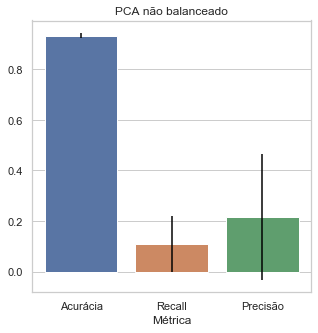

In [27]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

plot_unbalanced = pd.DataFrame(scores_unbalanced.loc[scores_unbalanced['Alpha'] == max_alpha_unbalanced, ['Accuracy']]).rename(columns={"Accuracy": "Value"})
plot_unbalanced['Métrica'] = 'Acurácia'

recall_unbalanced  = pd.DataFrame(scores_unbalanced.loc[scores_unbalanced['Alpha'] == max_alpha_unbalanced, ['Recall']]).rename(columns={"Recall": "Value"})
recall_unbalanced ['Métrica'] = 'Recall'
plot_unbalanced  = plot_unbalanced .append(recall_unbalanced )

presicion_unbalanced  = pd.DataFrame(scores_unbalanced.loc[scores_unbalanced['Alpha'] == max_alpha_unbalanced, ['Precision']]).rename(columns={"Precision": "Value"})
presicion_unbalanced ['Métrica'] = 'Precisão'
plot_unbalanced  = plot_unbalanced .append(presicion_unbalanced)

#plot

ax = sns.barplot(x="Métrica", y="Value", data=plot_unbalanced , ci = None)
plt.title('PCA não balanceado')

plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('PCA não balanceado', bbox_inches='tight', dpi=600)





ax.set(ylabel='')

[Text(152.00000000000003, 0.5, '')]

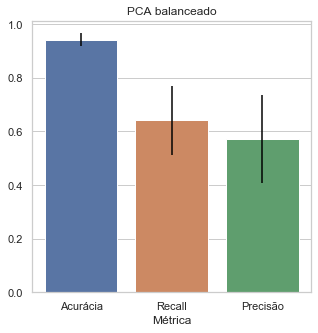

In [28]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

plot_balanced = pd.DataFrame(scores_balanced.loc[scores_balanced['Alpha'] == max_alpha_balanced, ['Accuracy']]).rename(columns={"Accuracy": "Value"})
plot_balanced['Métrica'] = 'Acurácia'

recall_balanced  = pd.DataFrame(scores_balanced.loc[scores_balanced['Alpha'] == max_alpha_balanced, ['Recall']]).rename(columns={"Recall": "Value"})
recall_balanced ['Métrica'] = 'Recall'
plot_balanced  = plot_balanced .append(recall_balanced )

presicion_balanced  = pd.DataFrame(scores_balanced.loc[scores_balanced['Alpha'] == max_alpha_balanced, ['Precision']]).rename(columns={"Precision": "Value"})
presicion_balanced ['Métrica'] = 'Precisão'
plot_balanced  = plot_balanced .append(presicion_balanced)

#plot

ax = sns.barplot(x="Métrica", y="Value", data=plot_balanced, ci =None )
plt.title('PCA balanceado')

plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('PCA balanceado', bbox_inches='tight', dpi=600)



ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [29]:
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 
score_min_unbalanced = pd.DataFrame([acc_min_unbalanced, rec_min_unbalanced, pre_min_unbalanced]).rename(columns = {0: 'Score'})
score_max_unbalanced =  pd.DataFrame([acc_max_unbalanced, rec_max_unbalanced, pre_max_unbalanced]).rename(columns = {0: 'Score'})
score_min_balanced = pd.DataFrame([acc_min_balanced, rec_min_balanced, pre_min_balanced]).rename(columns = {0: 'Score'})
score_max_balanced =  pd.DataFrame([acc_max_balanced, rec_max_balanced, pre_max_balanced]).rename(columns = {0: 'Score'})

path_to_save = '../../model_results/'

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    '6',
    'Naive Bayes',
    'PCA Desbalanceado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_unbalanced[metrica],score_min_unbalanced.loc[metrica]['Score'], score_max_unbalanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

for metrica in df_mean_balanced.index:
    result = [
    '6',
    'Naive Bayes',
    'PCA Balanceado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value'],
     '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_balanced[metrica],score_min_balanced.loc[metrica]['Score'], score_max_balanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao', 
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

,Algoritmo,Atividade,Condicao,Melhores_Params,Metrica,Valor,Intervalo_Confianca
0,SVC,7,Dataset Completo Desbalanceado - Nao Normalizado,"('linear', 1, 'scale')",Accuracy,0.960383,"[0.960, 0.944, 0.977]"
1,SVC,7,Dataset Completo Desbalanceado - Nao Normalizado,"('linear', 1, 'scale')",Recall,0.86,"[0.860, 0.764, 0.956]"
2,SVC,7,Dataset Completo Desbalanceado - Nao Normalizado,"('linear', 1, 'scale')",Precision,0.677579,"[0.678, 0.545, 0.810]"
3,SVC,7,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Accuracy,0.962709,"[0.963, 0.948, 0.978]"
4,SVC,7,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Recall,0.876667,"[0.877, 0.793, 0.960]"
5,SVC,7,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Precision,0.690079,"[0.690, 0.564, 0.816]"
6,SVC,7,Dataset Completo Desbalanceado - Normalizado,"('rbf', 100, '0.0001')",Accuracy,0.962709,"[0.963, 0.947, 0.978]"
7,SVC,7,Dataset Completo Desbalanceado - Normalizado,"('rbf', 100, '0.0001')",Recall,0.876667,"[0.877, 0.793, 0.960]"
8,SVC,7,Dataset Completo Desbalanceado - Normalizado,"('rbf', 100, '0.0001')",Precision,0.690079,"[0.690, 0.564, 0.816]"
9,SVC,7,Dataset Completo Balanceado - Normalizado,"('rbf', 100, '0.0001')",Accuracy,0.959193,"[0.959, 0.939, 0.979]"


Resultados salvos com sucesso
